# DATA620: Project 3 - Gender Identification

## Homework Team 3: David Simbandumwe, Eric Lehmphul and Lidiia Tronina

Your project should be submitted (as an Jupyter Notebook via GitHub). The team members should all submit a link to the same repository. If any of you don't submit the link to GitHub, I will assume you didn't collaborate.
Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

### Load Required Packages

In [29]:
import nltk
from nltk.corpus import names
from nltk.classify import apply_features
from nltk.probability import FreqDist
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

### Functions

In [30]:
# extract features
def gender_features1(name):
    features = {}
    #features["firstletter"] = name[0].lower()
    features["suffix1"] = name[-1].lower()
    features["suffix2"] = name[-2].lower()

    return features

### Import and Lable Names

In [31]:
names = ([(name, 'male') for name in names.words('male.txt')] +
        [(name, 'female') for name in names.words('female.txt')])
random.shuffle(names)

In [32]:
# analyze data
df = pd.DataFrame(names, columns=['name','gender'])
df2 = df.groupby(['name'])['name'].count().reset_index(name='count').sort_values(['count'], ascending=False)
df2 = df2[df2['count']>1]
name_df = pd.merge(df,df2,how="inner", on=["name"])
name_df

,name,gender,count
0,Danny,male,2
1,Danny,female,2
2,Del,male,2
3,Del,female,2
4,Evelyn,female,2
...,...,...,...
725,Toby,female,2
726,Maurise,female,2
727,Maurise,male,2
728,Lindsey,male,2


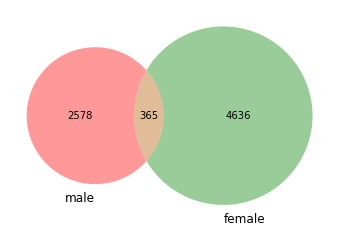

In [33]:
# Use the venn2 function
s1 = set(df[df['gender'] == 'male']['name'])
s2 = set(df[df['gender'] == 'female']['name'])
venn2([s1, s2], set_labels = ('male', 'female'))
plt.show()

### Split Corpus

In [34]:
train_names = names[1000:]
devtest_names = names[500:1000]
test_names = names[:500]

In [35]:
print('Size Train Set',len(train_names))
print('Size Development Set',len(devtest_names))
print('Size Test Set',len(test_names))

Size Train Set 6944
Size Development Set 500
Size Test Set 500


In [36]:
train_set = apply_features(gender_features1, train_names)
devtest_set = apply_features(gender_features1, devtest_names)
test_set = apply_features(gender_features1, test_names)

### Train Classifier

In [37]:
classifier = nltk.NaiveBayesClassifier.train(train_set) 

### Analyze Errors 

In [38]:
nltk.classify.accuracy(classifier, devtest_set)

0.786

In [39]:
errors = []
for (name, tag) in devtest_names:
    guess = classifier.classify(gender_features1(name))
    if guess != tag:
        errors.append( (tag, guess, name) ) 

In [40]:
for (tag, guess, name) in sorted(errors): # doctest: +ELLIPSIS +NORMALIZE_WHITESPACE 
    print ('correct=%-8s guess=%-8s name=%-30s' % (tag, guess, name))

correct=female   guess=male     name=Ainsley                       
correct=female   guess=male     name=Alex                          
correct=female   guess=male     name=Alexis                        
correct=female   guess=male     name=Angel                         
correct=female   guess=male     name=Ariel                         
correct=female   guess=male     name=Astrix                        
correct=female   guess=male     name=Bidget                        
correct=female   guess=male     name=Cam                           
correct=female   guess=male     name=Caron                         
correct=female   guess=male     name=Cat                           
correct=female   guess=male     name=Cordey                        
correct=female   guess=male     name=Crystal                       
correct=female   guess=male     name=Dian                          
correct=female   guess=male     name=Dix                           
correct=female   guess=male     name=Doris      